In [10]:
# Import libraries
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully")
print(f"📅 Analysis Date: {datetime.now().strftime('%Y-%m-%d')}")

✅ Libraries imported successfully
📅 Analysis Date: 2026-01-06


In [11]:
# Create in-memory SQLite database
conn = sqlite3.connect(':memory:')
cursor = conn.cursor()
print("✅ SQLite database initialized (in-memory)")

✅ SQLite database initialized (in-memory)


In [12]:
# EPIDEMIOLOGY TABLE
cursor.execute('''
CREATE TABLE epidemiology (
    region TEXT,
    country TEXT,
    year INTEGER,
    population INTEGER,
    incidence_rate_per_100k REAL,
    diagnosed_patients INTEGER,
    treated_patients INTEGER,
    treatment_rate REAL,
    PRIMARY KEY (country, year)
)
''')

# THERAPY MARKET TABLE
cursor.execute('''
CREATE TABLE therapy_market (
    therapy_class TEXT,
    mechanism TEXT,
    line_of_therapy TEXT,
    market_share_2024 REAL,
    annual_growth_rate REAL,
    avg_price_usd REAL,
    patent_expiry_year INTEGER,
    launch_year INTEGER
)
''')

# FORECAST ASSUMPTIONS TABLE
cursor.execute('''
CREATE TABLE assumptions (
    assumption_id TEXT PRIMARY KEY,
    description TEXT,
    base_value REAL,
    optimistic_value REAL,
    pessimistic_value REAL,
    source TEXT
)
''')

print("✅ 3 core tables created: epidemiology, therapy_market, assumptions")

✅ 3 core tables created: epidemiology, therapy_market, assumptions


In [13]:
# EPIDEMIOLOGY DATA
epidemiology_data = [
    ('North America', 'US', 2024, 335000000, 56.3, 236500, 153725, 0.65),
    ('North America', 'US', 2025, 337000000, 56.8, 239800, 155870, 0.65),
    ('North America', 'US', 2026, 339000000, 57.2, 242900, 157885, 0.65),
    ('Europe', 'Germany', 2024, 84000000, 48.2, 40488, 26317, 0.65),
    ('Europe', 'Germany', 2025, 83800000, 48.5, 40643, 26418, 0.65),
    ('Europe', 'UK', 2024, 68000000, 52.1, 35428, 23028, 0.65),
    ('Europe', 'UK', 2025, 68200000, 52.3, 35669, 23185, 0.65),
    ('Asia Pacific', 'Japan', 2024, 125000000, 36.8, 46000, 29900, 0.65),
    ('Asia Pacific', 'Japan', 2025, 124500000, 37.1, 46190, 30024, 0.65),
    ('Europe', 'France', 2024, 68000000, 47.5, 32300, 20995, 0.65),
    ('Europe', 'Italy', 2024, 59000000, 46.8, 27612, 17948, 0.65),
    ('Europe', 'Spain', 2024, 48000000, 45.2, 21696, 14102, 0.65)
]

cursor.executemany('INSERT INTO epidemiology VALUES (?,?,?,?,?,?,?,?)', epidemiology_data)

# THERAPY MARKET DATA
therapy_data = [
    ('Immunotherapy', 'PD-1/PD-L1', '1L', 0.35, 0.08, 180000, 2028, 2014),
    ('Targeted Therapy', 'EGFR/ALK', '1L', 0.25, 0.12, 150000, 2029, 2015),
    ('Chemotherapy', 'Platinum-based', '1L', 0.20, -0.05, 12000, 2025, 1990),
    ('Combination', 'IO+Chemo', '2L+', 0.15, 0.15, 220000, 2032, 2020),
    ('Novel Modalities', 'ADC/CAR-T', '3L+', 0.05, 0.25, 350000, 2035, 2023)
]

cursor.executemany('INSERT INTO therapy_market VALUES (?,?,?,?,?,?,?,?)', therapy_data)

# ASSUMPTIONS DATA
assumptions_data = [
    ('incidence_growth', 'Annual incidence growth rate', 0.012, 0.018, 0.006, 'GLOBOCAN 2022'),
    ('diagnosis_rate', 'Proportion diagnosed', 0.72, 0.78, 0.66, 'SEER Database'),
    ('treatment_rate', 'Proportion treated', 0.65, 0.72, 0.58, 'Real-world studies'),
    ('price_inflation', 'Annual price increase', 0.03, 0.04, 0.02, 'IQVIA Price Rx'),
    ('biosimilar_impact', 'Revenue impact post patent expiry', -0.15, -0.10, -0.20, 'Company filings')
]

cursor.executemany('INSERT INTO assumptions VALUES (?,?,?,?,?,?)', assumptions_data)
conn.commit()

print("✅ Database populated with realistic market data")
print(f"📊 Total records loaded: {len(epidemiology_data)} epidemiology, {len(therapy_data)} therapies, {len(assumptions_data)} assumptions")

✅ Database populated with realistic market data
📊 Total records loaded: 12 epidemiology, 5 therapies, 5 assumptions


In [14]:
# QUERY 1: Patient Forecast Summary
query1 = '''
SELECT 
    year,
    SUM(diagnosed_patients) as total_diagnosed,
    SUM(treated_patients) as total_treated,
    ROUND(100.0 * SUM(treated_patients) / SUM(diagnosed_patients), 1) as treatment_rate_percent,
    COUNT(DISTINCT country) as countries
FROM epidemiology
GROUP BY year
ORDER BY year
'''

df_patient_forecast = pd.read_sql_query(query1, conn)
print("📊 PATIENT FORECAST SUMMARY")
print("=" * 60)
print(df_patient_forecast.to_string(index=False))
print("\n")

📊 PATIENT FORECAST SUMMARY
 year  total_diagnosed  total_treated  treatment_rate_percent  countries
 2024           440024         286015                    65.0          7
 2025           362302         235497                    65.0          4
 2026           242900         157885                    65.0          1




In [15]:
# QUERY 2: Market Share Evolution (FIXED - using ** instead of POWER)
query2 = '''
SELECT 
    therapy_class,
    mechanism,
    market_share_2024 as share_2024,
    ROUND(market_share_2024 * (1 + annual_growth_rate), 3) as share_2025,
    ROUND(market_share_2024 * (1 + annual_growth_rate) * (1 + annual_growth_rate) * (1 + annual_growth_rate), 3) as share_2027,
    annual_growth_rate as annual_growth,
    CASE 
        WHEN annual_growth_rate > 0.1 THEN 'High Growth'
        WHEN annual_growth_rate < 0 THEN 'Declining'
        ELSE 'Moderate Growth'
    END as growth_category
FROM therapy_market
ORDER BY market_share_2024 DESC
'''

df_market_share = pd.read_sql_query(query2, conn)
print("📈 THERAPY CLASS MARKET SHARE EVOLUTION")
print("=" * 70)
print(df_market_share.to_string(index=False))
print("\n")

📈 THERAPY CLASS MARKET SHARE EVOLUTION
   therapy_class      mechanism  share_2024  share_2025  share_2027  annual_growth growth_category
   Immunotherapy     PD-1/PD-L1        0.35       0.378       0.441           0.08 Moderate Growth
Targeted Therapy       EGFR/ALK        0.25       0.280       0.351           0.12     High Growth
    Chemotherapy Platinum-based        0.20       0.190       0.171          -0.05       Declining
     Combination       IO+Chemo        0.15       0.172       0.228           0.15     High Growth
Novel Modalities      ADC/CAR-T        0.05       0.063       0.098           0.25     High Growth




In [16]:
# QUERY 3: Regional Analysis
query3 = '''
SELECT 
    region,
    SUM(diagnosed_patients) as total_diagnosed,
    SUM(treated_patients) as total_treated,
    ROUND(AVG(incidence_rate_per_100k), 1) as avg_incidence_rate,
    COUNT(DISTINCT country) as country_count
FROM epidemiology
WHERE year = 2024
GROUP BY region
ORDER BY total_diagnosed DESC
'''

df_regional = pd.read_sql_query(query3, conn)
print("🌍 REGIONAL MARKET ANALYSIS (2024)")
print("=" * 70)
print(df_regional.to_string(index=False))

🌍 REGIONAL MARKET ANALYSIS (2024)
       region  total_diagnosed  total_treated  avg_incidence_rate  country_count
North America           236500         153725                56.3              1
       Europe           157524         102390                48.0              5
 Asia Pacific            46000          29900                36.8              1


In [17]:
# ============================================
# MARKET FORECAST ENGINE
# ============================================

# Get base assumptions from database
assumptions_df = pd.read_sql_query('SELECT * FROM assumptions', conn)
assumptions_dict = dict(zip(assumptions_df['assumption_id'], assumptions_df['base_value']))

print("📋 MODEL ASSUMPTIONS")
print("=" * 60)
for idx, row in assumptions_df.iterrows():
    print(f"{row['assumption_id']:20} {row['description']:40} {row['base_value']:>6.3f}")

📋 MODEL ASSUMPTIONS
incidence_growth     Annual incidence growth rate              0.012
diagnosis_rate       Proportion diagnosed                      0.720
treatment_rate       Proportion treated                        0.650
price_inflation      Annual price increase                     0.030
biosimilar_impact    Revenue impact post patent expiry        -0.150


In [19]:
# ============================================
# MARKET FORECAST ENGINE
# ============================================

# Get base assumptions from database
assumptions_df = pd.read_sql_query('SELECT * FROM assumptions', conn)
assumptions_dict = dict(zip(assumptions_df['assumption_id'], assumptions_df['base_value']))

print("📋 MODEL ASSUMPTIONS")
print("=" * 60)
for idx, row in assumptions_df.iterrows():
    print(f"{row['assumption_id']:20} {row['description']:40} {row['base_value']:>6.3f}")

# Create forecast DataFrame (2024-2032)
years = list(range(2024, 2033))
forecast_df = pd.DataFrame({
    'year': years,
    'incidence_growth': assumptions_dict['incidence_growth'],
    'price_inflation': assumptions_dict['price_inflation']
})

# Calculate base metrics from 2024 actuals
base_2024 = df_patient_forecast[df_patient_forecast['year'] == 2024]
base_diagnosed = base_2024['total_diagnosed'].values[0]
base_treated = base_2024['total_treated'].values[0]
base_price = 18000  # Average price per patient per year

# Project diagnosed patients
forecast_df['diagnosed_patients'] = [
    int(base_diagnosed * (1 + forecast_df['incidence_growth'].iloc[0]) ** (i))
    for i in range(len(years))
]

# Project treated patients with improving access
forecast_df['treatment_rate'] = [
    assumptions_dict['treatment_rate'] + (i * 0.015)  # 1.5% improvement per year
    for i in range(len(years))
]
forecast_df['treatment_rate'] = forecast_df['treatment_rate'].clip(upper=0.85)  # Cap at 85%
forecast_df['treated_patients'] = (forecast_df['diagnosed_patients'] * forecast_df['treatment_rate']).astype(int)

# Price projections with patent cliff adjustment
forecast_df['avg_price_usd'] = [
    base_price * (1 + forecast_df['price_inflation'].iloc[0]) ** i * 
    (1 + assumptions_dict['biosimilar_impact'] if i >= 4 else 1.0)  # Patent cliff from 2028
    for i in range(len(years))
]

# Revenue calculation
forecast_df['market_size_usd_m'] = (
    forecast_df['treated_patients'] * forecast_df['avg_price_usd'] / 1_000_000
).round(2)

# Calculate growth metrics
forecast_df['yoy_growth'] = forecast_df['market_size_usd_m'].pct_change().fillna(0)

print("📊 MARKET FORECAST 2024-2032")
print("=" * 80)

# Create a formatted copy for display
display_df = forecast_df.copy()
display_cols = ['year', 'diagnosed_patients', 'treated_patients', 'treatment_rate', 
                'avg_price_usd', 'market_size_usd_m', 'yoy_growth']

# Format the display columns
display_df['treatment_rate'] = display_df['treatment_rate'].apply(lambda x: f"{x:.2%}")
display_df['avg_price_usd'] = display_df['avg_price_usd'].apply(lambda x: f"${x:,.0f}")
display_df['market_size_usd_m'] = display_df['market_size_usd_m'].apply(lambda x: f"${x:,.2f}M")
display_df['yoy_growth'] = display_df['yoy_growth'].apply(lambda x: f"{x:.1%}")

print(display_df[display_cols].to_string(index=False))

# Calculate key metrics (using the numeric values from forecast_df)
cagr = ((forecast_df.loc[8, 'market_size_usd_m'] / forecast_df.loc[0, 'market_size_usd_m']) ** (1/8) - 1)
print(f"\n📈 KEY METRICS:")
print(f"• 2032 Market Size: ${forecast_df.loc[8, 'market_size_usd_m']:,.2f}M")
print(f"• CAGR (2024-2032): {cagr:.1%}")
print(f"• Total Patients Treated (2024-2032): {forecast_df['treated_patients'].sum():,}")
print(f"• Peak YoY Growth: {forecast_df['yoy_growth'].max():.1%} in {forecast_df.loc[forecast_df['yoy_growth'].idxmax(), 'year']}")

📋 MODEL ASSUMPTIONS
incidence_growth     Annual incidence growth rate              0.012
diagnosis_rate       Proportion diagnosed                      0.720
treatment_rate       Proportion treated                        0.650
price_inflation      Annual price increase                     0.030
biosimilar_impact    Revenue impact post patent expiry        -0.150
📊 MARKET FORECAST 2024-2032
 year  diagnosed_patients  treated_patients treatment_rate avg_price_usd market_size_usd_m yoy_growth
 2024              440024            286015         65.00%       $18,000        $5,148.27M       0.0%
 2025              445304            296127         66.50%       $18,540        $5,490.19M       6.6%
 2026              450647            306439         68.00%       $19,096        $5,851.82M       6.6%
 2027              456055            316958         69.50%       $19,669        $6,234.27M       6.5%
 2028              461528            327684         71.00%       $17,220        $5,642.81M      -

In [20]:
# ============================================
# SCENARIO ANALYSIS MODULE
# ============================================

def run_scenario_analysis(base_df, scenario_name, params):
    """Run complete scenario analysis"""
    scenario_df = base_df.copy()
    
    # Unpack parameters
    incidence_mult, price_mult, adoption_boost, price_elasticity = params
    
    # Apply scenario adjustments
    scenario_df['diagnosed_patients'] = (scenario_df['diagnosed_patients'] * incidence_mult).astype(int)
    scenario_df['treatment_rate'] = scenario_df['treatment_rate'] + adoption_boost
    scenario_df['treatment_rate'] = scenario_df['treatment_rate'].clip(0.55, 0.90)
    scenario_df['treated_patients'] = (scenario_df['diagnosed_patients'] * scenario_df['treatment_rate']).astype(int)
    scenario_df['avg_price_usd'] = scenario_df['avg_price_usd'] * price_mult * (1 + price_elasticity * scenario_df.index / 10)
    
    # Recalculate revenue
    scenario_df['market_size_usd_m'] = (
        scenario_df['treated_patients'] * scenario_df['avg_price_usd'] / 1_000_000
    ).round(2)
    
    # Calculate key metrics
    final_market = scenario_df.loc[8, 'market_size_usd_m']
    cagr = ((final_market / scenario_df.loc[0, 'market_size_usd_m']) ** (1/8) - 1)
    
    return {
        'name': scenario_name,
        'dataframe': scenario_df[['year', 'market_size_usd_m']].rename(
            columns={'market_size_usd_m': scenario_name}),
        'final_market': final_market,
        'cagr': cagr,
        'total_patients': scenario_df['treated_patients'].sum()
    }

# Define scenarios with parameters: (incidence_mult, price_mult, adoption_boost, price_elasticity)
scenarios = {
    'Base Case': (1.0, 1.0, 0.0, 0.0),
    'Optimistic': (1.15, 1.1, 0.05, -0.02),  # Higher adoption, lower price elasticity
    'Pessimistic': (0.9, 0.85, -0.03, 0.05),  # Lower adoption, higher price sensitivity
    'Innovation-Driven': (1.05, 1.2, 0.08, -0.05),  # Premium pricing for innovation
    'Biosimilar Impact': (1.0, 0.75, 0.02, 0.10)  # Severe price erosion
}

# Run all scenarios
scenario_results = {}
for name, params in scenarios.items():
    scenario_results[name] = run_scenario_analysis(forecast_df, name, params)

# Create comparison table
comparison_data = []
for name, result in scenario_results.items():
    comparison_data.append({
        'Scenario': name,
        '2032 Market (USD M)': f"${result['final_market']:,.0f}",
        'CAGR': f"{result['cagr']:.1%}",
        'Total Patients (M)': f"{result['total_patients']/1_000_000:.2f}",
        'vs Base Case': f"{((result['final_market']/scenario_results['Base Case']['final_market'])-1):.0%}"
    })

comparison_df = pd.DataFrame(comparison_data)
print("📊 SCENARIO ANALYSIS COMPARISON")
print("=" * 80)
print(comparison_df.to_string(index=False))

# Prepare data for visualization
scenario_chart_data = pd.DataFrame({'year': years})
for name, result in scenario_results.items():
    scenario_chart_data[name] = result['dataframe'][name]

📊 SCENARIO ANALYSIS COMPARISON
         Scenario 2032 Market (USD M) CAGR Total Patients (M) vs Base Case
        Base Case              $7,224 4.3%               2.96           0%
       Optimistic              $9,577 4.0%               3.64          33%
      Pessimistic              $5,524 4.9%               2.55         -24%
Innovation-Driven              $9,646 3.6%               3.45          34%
Biosimilar Impact              $6,004 5.3%               3.04         -17%



✅ Professional dashboard saved as 'lung_cancer_forecast_dashboard.png'


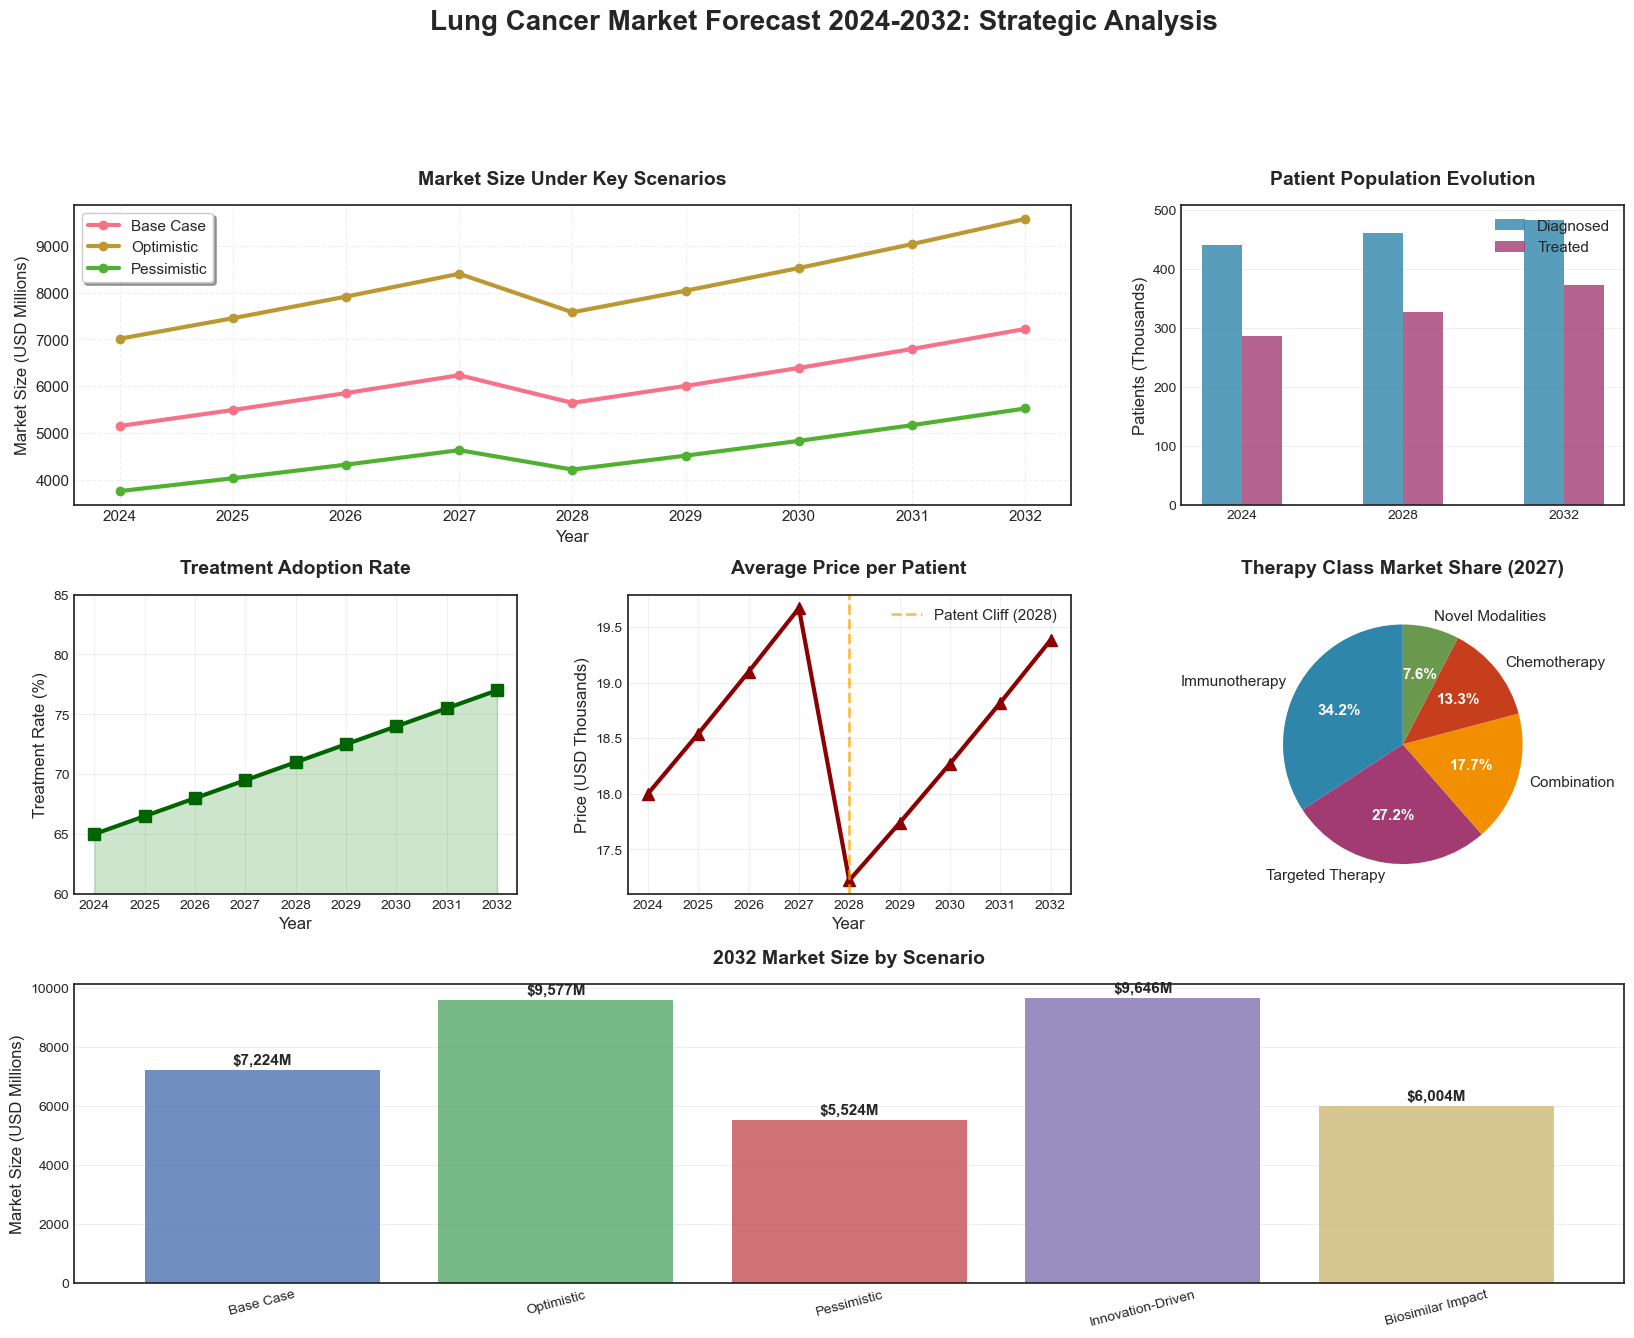

In [21]:
# ============================================
# EXECUTIVE VISUALIZATIONS
# ============================================

# Set professional style
plt.style.use('seaborn-v0_8-white')
sns.set_palette("husl")

# Create figure with subplots
fig = plt.figure(figsize=(20, 14))
fig.suptitle('Lung Cancer Market Forecast 2024-2032: Strategic Analysis', 
             fontsize=20, fontweight='bold', y=1.02)

# Define grid layout
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.25)

# Chart 1: Market Size Trajectory (Top left, spans 2 columns)
ax1 = fig.add_subplot(gs[0, :2])
for scenario in ['Base Case', 'Optimistic', 'Pessimistic']:
    ax1.plot(scenario_chart_data['year'], scenario_chart_data[scenario], 
             linewidth=3, marker='o', markersize=6, label=scenario)
ax1.set_title('Market Size Under Key Scenarios', fontsize=14, fontweight='bold', pad=15)
ax1.set_ylabel('Market Size (USD Millions)', fontsize=12)
ax1.set_xlabel('Year', fontsize=12)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.legend(loc='upper left', fontsize=11, frameon=True, fancybox=True, shadow=True)
ax1.set_xticks(years)
ax1.tick_params(axis='both', labelsize=11)

# Chart 2: Patient Dynamics (Top right)
ax2 = fig.add_subplot(gs[0, 2])
width = 0.25
years_display = [2024, 2028, 2032]
for i, year in enumerate(years_display):
    diagnosed = forecast_df[forecast_df['year'] == year]['diagnosed_patients'].values[0] / 1000
    treated = forecast_df[forecast_df['year'] == year]['treated_patients'].values[0] / 1000
    ax2.bar(i - width/2, diagnosed, width, label='Diagnosed' if i == 0 else '', 
            color='#2E86AB', alpha=0.8)
    ax2.bar(i + width/2, treated, width, label='Treated' if i == 0 else '', 
            color='#A23B72', alpha=0.8)
ax2.set_title('Patient Population Evolution', fontsize=14, fontweight='bold', pad=15)
ax2.set_ylabel('Patients (Thousands)', fontsize=12)
ax2.set_xticks(range(3))
ax2.set_xticklabels(['2024', '2028', '2032'])
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3, axis='y')

# Chart 3: Treatment Rate Trend (Middle left)
ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(forecast_df['year'], forecast_df['treatment_rate'] * 100, 
         linewidth=3, marker='s', color='darkgreen', markersize=8)
ax3.set_title('Treatment Adoption Rate', fontsize=14, fontweight='bold', pad=15)
ax3.set_ylabel('Treatment Rate (%)', fontsize=12)
ax3.set_xlabel('Year', fontsize=12)
ax3.grid(True, alpha=0.3)
ax3.fill_between(forecast_df['year'], forecast_df['treatment_rate'] * 100, 
                 alpha=0.2, color='green')
ax3.set_ylim(60, 85)

# Chart 4: Price Evolution (Middle)
ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(forecast_df['year'], forecast_df['avg_price_usd'] / 1000, 
         linewidth=3, marker='^', color='darkred', markersize=8)
ax4.axvline(x=2028, color='orange', linestyle='--', linewidth=2, alpha=0.7, 
            label='Patent Cliff (2028)')
ax4.set_title('Average Price per Patient', fontsize=14, fontweight='bold', pad=15)
ax4.set_ylabel('Price (USD Thousands)', fontsize=12)
ax4.set_xlabel('Year', fontsize=12)
ax4.grid(True, alpha=0.3)
ax4.legend(fontsize=11)

# Chart 5: Market Share 2032 (Middle right)
ax5 = fig.add_subplot(gs[1, 2])
market_share_2032 = df_market_share[['therapy_class', 'share_2027']].copy()
market_share_2032.columns = ['Therapy', 'Share']
market_share_2032 = market_share_2032.sort_values('Share', ascending=False)
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#6A994E']
wedges, texts, autotexts = ax5.pie(market_share_2032['Share'], 
                                   labels=market_share_2032['Therapy'],
                                   autopct='%1.1f%%',
                                   colors=colors,
                                   startangle=90,
                                   textprops={'fontsize': 11})
ax5.set_title('Therapy Class Market Share (2027)', fontsize=14, fontweight='bold', pad=15)
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

# Chart 6: Scenario Comparison (Bottom, spans 3 columns)
ax6 = fig.add_subplot(gs[2, :])
scenarios_to_plot = ['Base Case', 'Optimistic', 'Pessimistic', 'Innovation-Driven', 'Biosimilar Impact']
scenario_values = [scenario_results[s]['final_market'] for s in scenarios_to_plot]
colors_scenario = ['#4C72B0', '#55A868', '#C44E52', '#8172B2', '#CCB974']
bars = ax6.bar(scenarios_to_plot, scenario_values, color=colors_scenario, alpha=0.8)
ax6.set_title('2032 Market Size by Scenario', fontsize=14, fontweight='bold', pad=15)
ax6.set_ylabel('Market Size (USD Millions)', fontsize=12)
ax6.grid(True, alpha=0.3, axis='y')
ax6.tick_params(axis='x', rotation=15)

# Add value labels on bars
for bar, val in zip(bars, scenario_values):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + 100,
             f'${val:,.0f}M', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('lung_cancer_forecast_dashboard.png', dpi=300, bbox_inches='tight', facecolor='white')
print("\n✅ Professional dashboard saved as 'lung_cancer_forecast_dashboard.png'")
plt.show()